Saving date_promovare_examen.csv to date_promovare_examen (9).csv
['Ore_Studiu', 'Ore_Somn', 'Promovare']
folosit_y: promovare folosit_x: ['ore_studiu', 'ore_somn']
1    250
0    250
Name: count, dtype: int64
1    0.5
0    0.5
Name: proportion, dtype: float64


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

divergences: 0


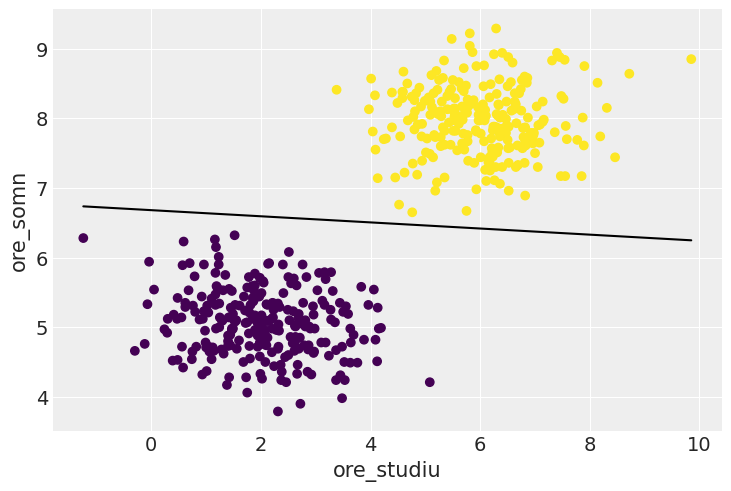

accuracy: 1.0
auc: 1.0
       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
β[0]   0.84  1.197  -0.798    2.946      0.036    0.072    2060.0    1323.0   
β[1]  13.17  7.760   3.198   25.745      0.234    0.689    1747.0    1529.0   

      r_hat  
β[0]    1.0  
β[1]    1.0  
P(|β_somn| > |β_studiu|) = 0.98125
P(β_studiu > 0) = 0.82775
P(β_somn > 0) = 1.0


In [14]:
# a) verificarea balansării datelor și construcția modelului de regresie logistică Bayesiană
!pip -q install pymc arviz numpyro

from google.colab import files
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import re, unicodedata

uploaded = files.upload()
CSV_PATH = list(uploaded.keys())[0]
df = pd.read_csv(CSV_PATH)

def _norm(s):
    s = str(s)
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("ascii")
    s = s.strip().lower()
    s = re.sub(r"[^\w]+", "_", s)
    s = re.sub(r"_+", "_", s).strip("_")
    return s

df_n = df.rename(columns={c: _norm(c) for c in df.columns})

y_col = "promovare" if "promovare" in df_n.columns else ("promovat" if "promovat" in df_n.columns else df_n.columns[-1])
x1_col = "ore_studiu" if "ore_studiu" in df_n.columns else df_n.columns[0]
x2_col = "ore_somn" if "ore_somn" in df_n.columns else df_n.columns[1]

X_raw = df_n[[x1_col, x2_col]].apply(pd.to_numeric, errors="coerce")
y_raw = df_n[y_col]

if pd.api.types.is_numeric_dtype(y_raw):
    y_num = pd.to_numeric(y_raw, errors="coerce")
else:
    y_s = y_raw.astype(str).str.strip().str.lower().replace({
        "da":"1","nu":"0","yes":"1","no":"0","true":"1","false":"0",
        "promovat":"1","nepromovat":"0","admis":"1","respins":"0"
    })
    y_num = pd.to_numeric(y_s, errors="coerce")

mask = (~X_raw.isna().any(axis=1)) & (~y_num.isna())
X = X_raw.loc[mask].values
y = y_num.loc[mask].astype(int).values

print(df.columns.tolist())
print("folosit_y:", y_col, "folosit_x:", [x1_col, x2_col])
print(pd.Series(y).value_counts())
print(pd.Series(y).value_counts(normalize=True).rename("proportion"))

X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_s = (X - X_mean) / X_std

with pm.Model() as model:
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.StudentT("β", nu=4, mu=0, sigma=0.5, shape=2)
    μ = α + pm.math.dot(X_s, β)
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))
    yl = pm.Bernoulli("yl", logit_p=μ, observed=y)
    idata = pm.sample(
        2000, tune=2000, chains=4,
        target_accept=0.99, max_treedepth=15,
        init="jitter+adapt_diag",
        nuts_sampler="numpyro",
        return_inferencedata=True,
        random_seed=42
    )

print("divergences:", int(idata.sample_stats["diverging"].sum().values))


# b) frontiera medie de decizie și separabilitatea datelor
post = idata.posterior.stack(s=("chain", "draw"))
αm = float(post["α"].mean("s").values)
βs = post["β"].values
βm = βs.mean(axis=1).astype(float)

x1_line = np.linspace(X[:,0].min(), X[:,0].max(), 300)
x1_line_s = (x1_line - X_mean[0]) / X_std[0]

if abs(βm[1]) < 1e-8:
    x2_line = np.full_like(x1_line, np.nan)
else:
    x2_line_s = -(αm + βm[0] * x1_line_s) / βm[1]
    x2_line = x2_line_s * X_std[1] + X_mean[1]

plt.scatter(X[:,0], X[:,1], c=y)
plt.plot(x1_line, x2_line, color="k")
plt.xlabel(x1_col)
plt.ylabel(x2_col)
plt.show()

μ_mean = αm + X_s @ βm
p_mean = 1 / (1 + np.exp(-μ_mean))
y_hat = (p_mean >= 0.5).astype(int)

acc = (y_hat == y).mean()
p0 = p_mean[y == 0]
p1 = p_mean[y == 1]
auc = (np.mean(p1[:, None] > p0[None, :]) + 0.5 * np.mean(p1[:, None] == p0[None, :])) if (len(p0) and len(p1)) else np.nan

print("accuracy:", float(acc))
print("auc:", float(auc))


# c) influența orelor de studiu vs. somn
print(az.summary(idata, var_names=["β"]))
prob_abs_sleep_gt_study = float(np.mean(np.abs(βs[1]) > np.abs(βs[0])))
prob_study_pos = float(np.mean(βs[0] > 0))
prob_sleep_pos = float(np.mean(βs[1] > 0))
print("P(|β_somn| > |β_studiu|) =", prob_abs_sleep_gt_study)
print("P(β_studiu > 0) =", prob_study_pos)
print("P(β_somn > 0) =", prob_sleep_pos)
